<a href="https://colab.research.google.com/github/kbtran93/aapl-stock-prediction/blob/main/aapl_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Apple Stock Prediction**

In [10]:
# Import required modules
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dateutil.parser import parse
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn import linear_model
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.utils.vis_utils import plot_model

In [14]:
from google.colab import files
uploaded = files.upload()

Saving AAPL.csv to AAPL (1).csv


In [15]:
import io
# Import the data
df = pd.read_csv(io.StringIO(uploaded['AAPL.csv'].decode('utf-8')))
df.head()
# Describe the data
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10272.000000,10272.000000,10272.000000,10272.000000,10272.000000,1.027200e+04
mean,12.006819,12.134860,11.877629,12.011191,11.420584,3.353832e+08
std,25.111332,25.388548,24.833693,25.123982,24.816645,3.404297e+08
min,0.049665,0.049665,0.049107,0.049107,0.038490,0.000000e+00
25%,0.276786,0.284375,0.270089,0.276964,0.232579,1.273552e+08
50%,0.456451,0.464286,0.446987,0.455357,0.378405,2.233742e+08
75%,12.687857,12.825715,12.579018,12.687143,10.893390,4.177250e+08
max,156.979996,157.259995,154.389999,156.690002,156.690002,7.421641e+09


In [16]:
# Convert the Date column to datetime
df.Date = pd.to_datetime(df.Date, infer_datetime_format=True)

# Set the Date as index
df.set_index('Date', inplace=True)
df.index

DatetimeIndex(['1980-12-12', '1980-12-15', '1980-12-16', '1980-12-17',
               '1980-12-18', '1980-12-19', '1980-12-22', '1980-12-23',
               '1980-12-24', '1980-12-26',
               ...
               '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-30',
               '2021-08-31', '2021-09-01', '2021-09-02', '2021-09-03',
               '2021-09-07', '2021-09-08'],
              dtype='datetime64[ns]', name='Date', length=10272, freq=None)

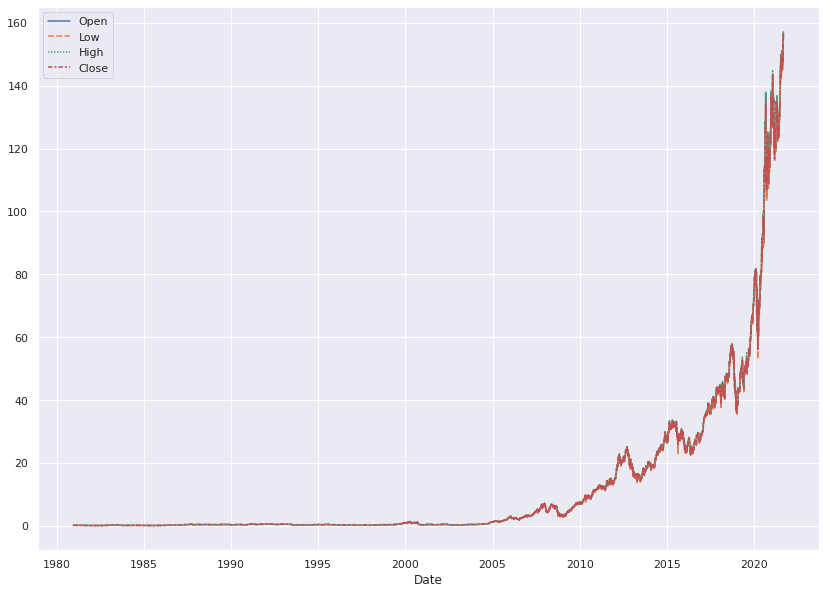

In [17]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
ax = sns.lineplot(data=df[['Open', 'Low', 'High', 'Close']])

In [18]:
# Set Target Variable
output_var = pd.DataFrame(df['Adj Close'])

# Selecting the Features
features = ['Open', 'High','Low','Volume']

In [19]:
# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
1980-12-12,0.000501,0.000504,0.000513,0.063198
1980-12-15,0.000462,0.000461,0.000470,0.023699
1980-12-16,0.000405,0.000405,0.000412,0.014246
1980-12-17,0.000420,0.000422,0.000430,0.011647
1980-12-18,0.000441,0.000444,0.000452,0.009897


In [20]:
# Splitting to Training set and Test set
timesplit = TimeSeriesSplit(n_splits=10)

for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()


In [21]:
# Process the data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

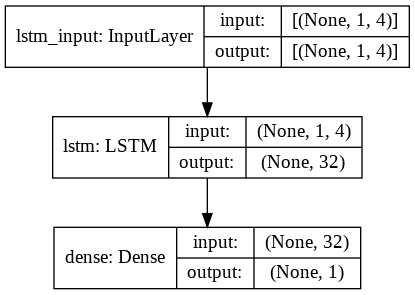

In [22]:
# Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [23]:
# Model Training
history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
1168/1168 [==============================] - 4s 2ms/step - loss: 2.7450
Epoch 2/100
1168/1168 [==============================] - 2s 2ms/step - loss: 30.5034
Epoch 3/100
1168/1168 [==============================] - 2s 2ms/step - loss: 6.9761
Epoch 4/100
1168/1168 [==============================] - 2s 2ms/step - loss: 1.4955
Epoch 5/100
1168/1168 [==============================] - 2s 2ms/step - loss: 0.2306
Epoch 6/100
1168/1168 [==============================] - 2s 2ms/step - loss: 0.0593
Epoch 7/100
1168/1168 [==============================] - 2s 2ms/step - loss: 0.0318
Epoch 8/100
1168/1168 [==============================] - 2s 2ms/step - loss: 0.0243
Epoch 9/100
1168/1168 [==============================] - 2s 2ms/step - loss: 0.0216
Epoch 10/100
1168/1168 [==============================] - 2s 2ms/step - loss: 0.0203
Epoch 11/100
1168/1168 [==============================] - 2s 2ms/step - loss: 0.0196
Epoch 12/100
1168/1168 [==============================] - 2s 2ms/step - l

In [24]:
# LSTM Prediction
y_pred= lstm.predict(X_test)

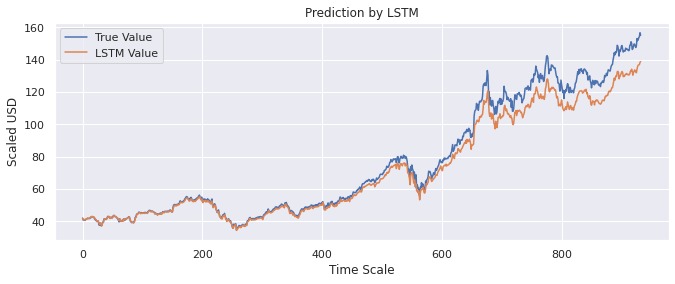

In [25]:
# True vs Predicted Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()